In [11]:
from vegetation.preprocessing.ndvi_prep import remove_ndvi_outliers
import os 
import xarray as xr
from utils.function_clns import config
import logging
from vegetation.preprocessing.ndvi_prep import load_eumetsat_ndvi_max
from dask.diagnostics import ProgressBar
import pyproj
from vegetation.preprocessing.ndvi_prep import NDVIPreprocess
import numpy as np

baseline_path = config["DEFAULT"]["local"] #config["NDVI"]["ndvi_path"]

os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

chunks={"time":-1, "lat":90, "lon":90}
filename = "seviri_full_image_smoothed.zarr"
ds_clean = xr.open_zarr(os.path.join(baseline_path, filename), 
                        chunks=chunks)
streaks_data = xr.open_zarr(os.path.join(
    baseline_path, 
    "mask_num_streaks.zarr"),
    chunks=chunks)

# Step 2: Calculate length of each streak
total_length = streaks_data.streaks.sum(dim='time')
num_streaks = streaks_data.streaks.count(dim='time')
days = len(streaks_data["time"])
max_strike = streaks_data.streaks.max(dim='time')

# Step 3: Calculate average
average_length = total_length / num_streaks
fraction_streaks = total_length/days

ds_clean["ndvi_clean"] = ds_clean["ndvi"].where(streaks_data.quality_flag<=45)
ds_clean["ndvi_clean"] = remove_ndvi_outliers(ds_clean["ndvi_clean"], impute=True)

filepath = os.path.join(baseline_path, "seviri_daily_ndvimax.nc")
max_ndvi = load_eumetsat_ndvi_max(filepath, 
                                  chunks=chunks)
modis_ds = xr.open_zarr(os.path.join(baseline_path, "ndvi_daily_modis.zarr"),
                        chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

ds_ndvi = NDVIPreprocess(ds_clean["ndvi_clean"]).get_processed_data()
max_ndvi = NDVIPreprocess(max_ndvi).get_processed_data()
modis_ndvi = NDVIPreprocess(modis_ds["ndvi"]).get_processed_data()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The speci

In [12]:
from utils.function_clns import prepare, align_datasets
from utils.xarray_functions import odc_reproject
import pandas as pd
from rasterio.enums import Resampling
chunks = {"time":-1, "lat":80, "lon":80}

# geobox_eumetsat = geobox_from_rio(max_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu = odc_reproject(ds_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu["lat"] = max_ndvi["lat"]
ds_repr_eu["lon"] = max_ndvi["lon"]

ds1, ds2 = align_datasets(ds_repr_eu, max_ndvi, chunks=chunks)
logging.info("Succesfully reprojected our dataset")

ds_repr_mod = odc_reproject(modis_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod["lat"] = max_ndvi["lat"]
ds_repr_mod["lon"] = max_ndvi["lon"]

ds3, ds4 = align_datasets(ds_repr_mod, max_ndvi, chunks=chunks)
ds5, ds6 = align_datasets(ds_repr_mod, ds_repr_eu, chunks=chunks)

INFO:root:Starting reprojecting...
INFO:root:Succesfully reprojected our dataset


In [ ]:
import xskillscore as xs

def print_metrics(corr, rmse, string1, string2):
    print(f"mean correlation between {string1} and {string2} is", corr.mean().values)
    print(f"mean rmse between {string1} and {string2} is", rmse.mean().values)
    # print(f"mean mae between {string1} and {string2} is", mae.mean().values)
    # print(f"mean mape between {string1} and {string2} is", mape.mean().values)

### Ours with EUMETSAT
with ProgressBar():
    # corr_a = xs.pearson_r(ds1, ds2, dim="time", skipna=True).load()
    # rmse_a = xs.rmse(ds1, ds2, dim="time", skipna=True).load()
    # # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    # print_metrics(corr_a, rmse_a,"OURS", "EUMETSAT")

    ### Ours with MODIS
    corr_b = xs.pearson_r(ds4, ds3, dim="time", skipna=True).load()
    rmse_b = xs.rmse(ds4, ds3, dim="time", skipna=True).load()
    # mae_b = xs.mae(ds4, ds3, dim="time", skipna=True)
    # mape_b = xs.mape(ds4, ds3, dim="time", skipna=True)
    print_metrics(corr_b, rmse_b,"OURS", "MODIS")

    ### EUMETSAT with MODIS
    corr_c = xs.pearson_r(ds5, ds6, dim="time", skipna=True).load()
    rmse_c = xs.rmse(ds5, ds6, dim="time", skipna=True).load()
    # mae_c = xs.mae(ds5, ds6, dim="time", skipna=True)
    # mape_c = xs.mape(ds5, ds6, dim="time", skipna=True)
    print_metrics(corr_c, rmse_c,"EUMETSAT", "MODIS")

[########################################] | 100% Completed | 52m 55s
[########################################] | 100% Completed | 50m 24s
mean correlation between OURS and MODIS is 0.49575216
mean rmse between OURS and MODIS is 0.12813774
[########################################] | 100% Completed | 2hr 39m
[########################################] | 100% Completed | 2hr 22m
mean correlation between EUMETSAT and MODIS is 0.42752737
mean rmse between EUMETSAT and MODIS is 0.12883358


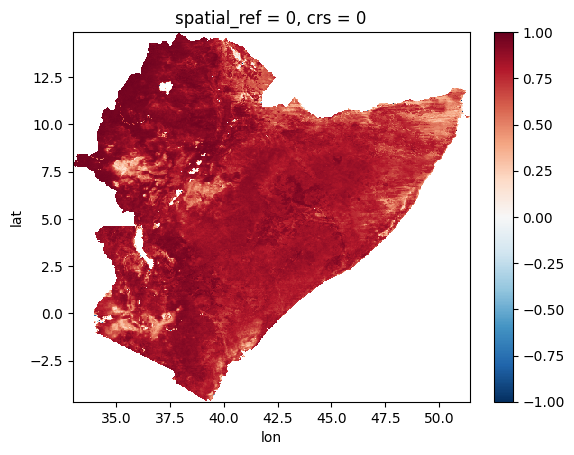

In [ ]:
corr_a.plot()

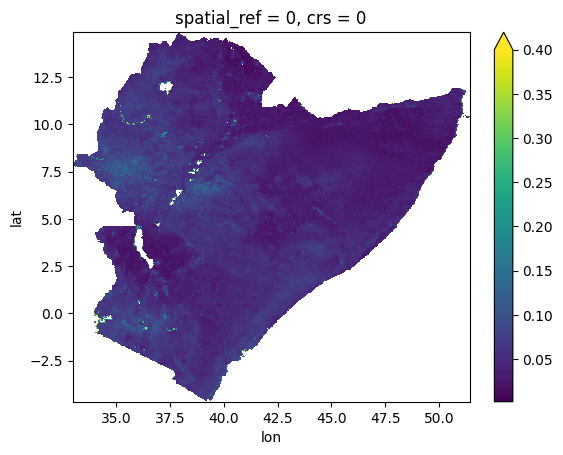

In [ ]:
rmse_a.plot(vmax=0.4)

In [ ]:
# Extract predicted and real values
import numpy as np

predicted_values = ds1.values.flatten()
real_values = ds2.values.flatten()

arr1 = predicted_values[~np.isnan(predicted_values)]
arr2 = real_values[~np.isnan(real_values)]

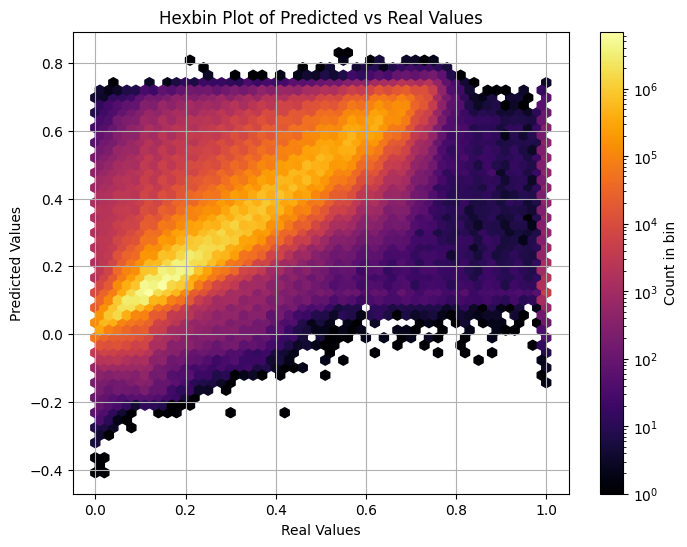

In [ ]:
import matplotlib.pyplot as plt
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='inferno')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Autocorrelation

In [ ]:
from vegetation.analysis.indices import autocorr
import matplotlib.pyplot as plt

lags = 30

lead_cunk = {"lat":"auto", "lon":"auto", "lead":"auto"}
auto_ds1 = autocorr(ds1, nlags=lags, skipna=True)
auto_ds2 = autocorr(ds2, nlags=lags, skipna=True)
auto_ds3 = autocorr(ds3, nlags=lags, skipna=True)

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

[#                                       ] | 4% Completed | 26.73 sms

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


[########################################] | 100% Completed | 270.24 s
[########################################] | 100% Completed | 136.13 s
[########################################] | 100% Completed | 13m 14s


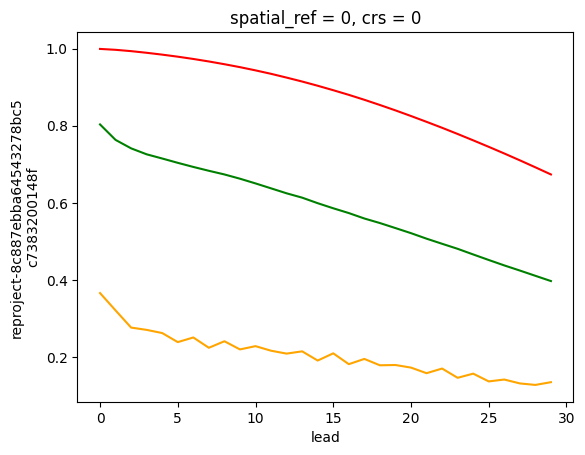

In [ ]:
with ProgressBar():
    auto_mean_3 = auto_ds3.mean(["lat","lon"])
    auto_mean_1 = auto_ds1.mean(["lat","lon"])
    auto_mean_2 = auto_ds2.mean(["lat","lon"])
    auto_mean_3.plot(color="orange")
    auto_mean_2.plot(color="green")
    auto_mean_1.plot(color="red")
    plt.show()

In [ ]:
from ancillary.esa_landuse import get_level_1, create_copernicus_covermap
from utils.function_clns import subsetting_pipeline

cover_ds = create_copernicus_covermap(ds1)
cover_ds = subsetting_pipeline(cover_ds)
cover_ds["lat"] = ds1["lat"]
cover_ds["lon"] = ds1["lon"]
cover_ds = get_level_1(cover_ds, name="band_data").isel(band=0)

fraction_repr = prepare(fraction_streaks).rio.reproject_match(prepare(cover_ds))
green_mask = xr.where(((cover_ds["band_data"].isin([11,12])) \
                      & (prepare(fraction_repr)>=0.5))
                      , 1, 0 ).transpose("lat","lon")

Loading extisting landcover dataset


In [ ]:
from typing import Union
import numpy as np

def select_random_points(mask: Union[xr.DataArray, xr.Dataset, None] = None,
                         n_points: int = 1):
    # Step 1: Apply boolean mask
    valid_indices = np.where(mask == 1)

    # Step 2: Generate random indices
    random_indices = np.random.choice(len(valid_indices[0]), 
                                      size=n_points, replace=False)
    
    return valid_indices, random_indices

def plot_random_masked_over_time(data_array1: Union[xr.DataArray, xr.Dataset],
                                 valid_indices:tuple, 
                                 random_indices:np.ndarray,
                                 date_min:str = None,
                                 date_max:str = None):
    
    if date_max and date_max is not None:
        data_array1 = data_array1.sel(time=slice(date_min, date_max))

    n_points = len(random_indices)

    # Step 3: Retrieve latitudes and longitudes corresponding to selected indices
    selected_lats = data_array1.lat.values[valid_indices[0][random_indices]]
    selected_lons = data_array1.lon.values[valid_indices[1][random_indices]]

    # Step 4: Generate time axis
    time_axis = data_array1.time.values

    # Step 5: Plot latitude-longitude combinations over time
    plt.figure(figsize=(10, 6))
    for i in range(n_points):
        plt.plot(time_axis, data_array1.sel(lat=selected_lats[i], lon=selected_lons[i]),
                 label=f'Lat: {selected_lats[i]}, Lon: {selected_lons[i]}', 
                 color=plt.cm.viridis(i / n_points), linestyle='-', marker='o', markersize=4, alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Data Variable')
    plt.title('Latitude-Longitude Combinations Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
start_date = "2017-01-01"
end_date = "2019-01-01"
n= 5

valid_indices, random_indices = select_random_points(green_mask, 
                                                     n_points = n)
# random_indices = [ 8289, 10619, 12757, 13611, 13922]

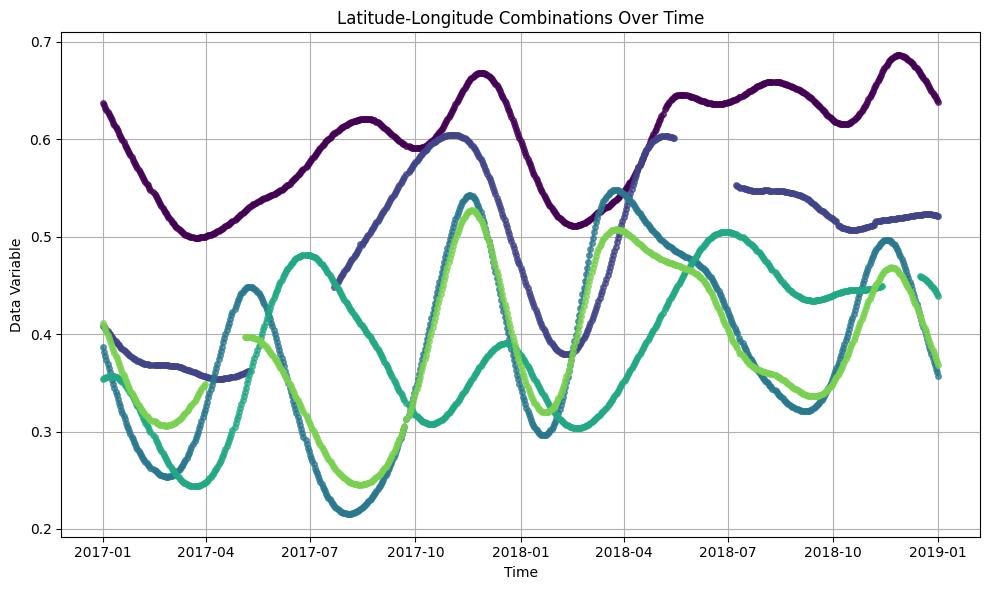

In [ ]:
# from analysis.visualizations.viz_series import plot_random_masked_over_time
import matplotlib.pyplot as plt
plot_random_masked_over_time(ds1, valid_indices, 
                             random_indices, start_date, end_date)

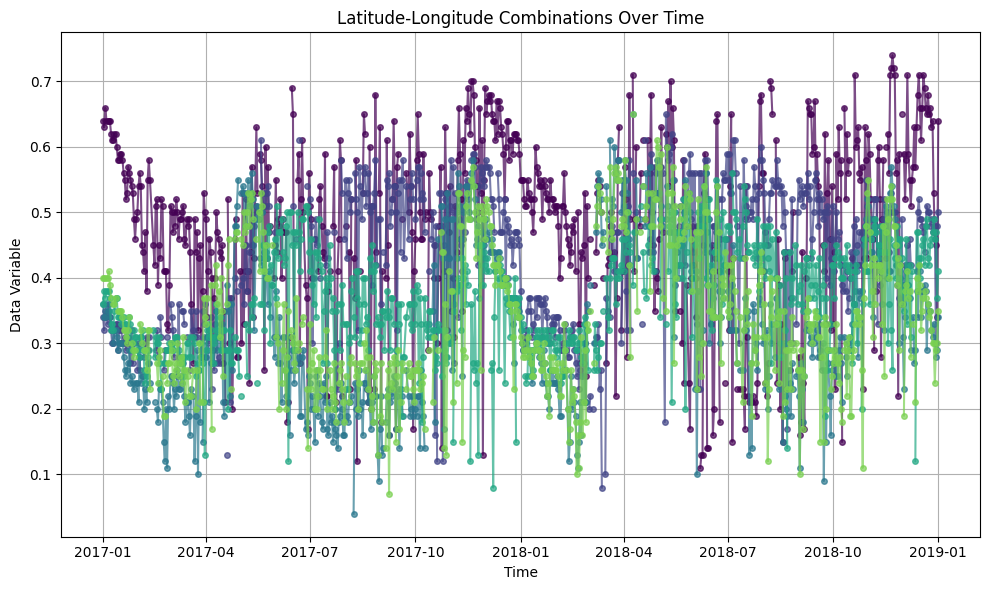

In [ ]:
plot_random_masked_over_time(ds2, valid_indices, random_indices, start_date, end_date)

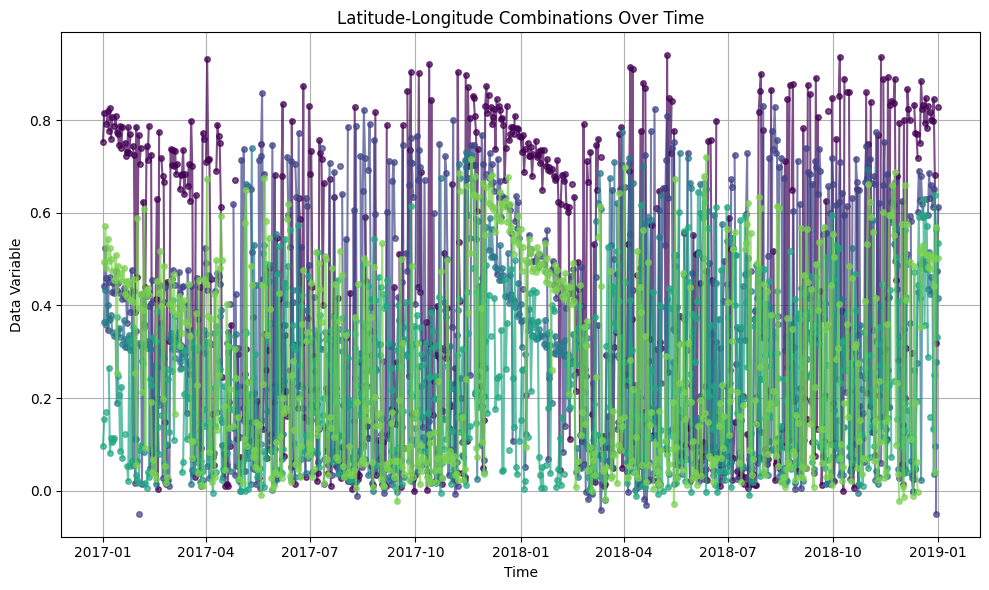

In [ ]:
plot_random_masked_over_time(ds3, valid_indices, random_indices, start_date, end_date)

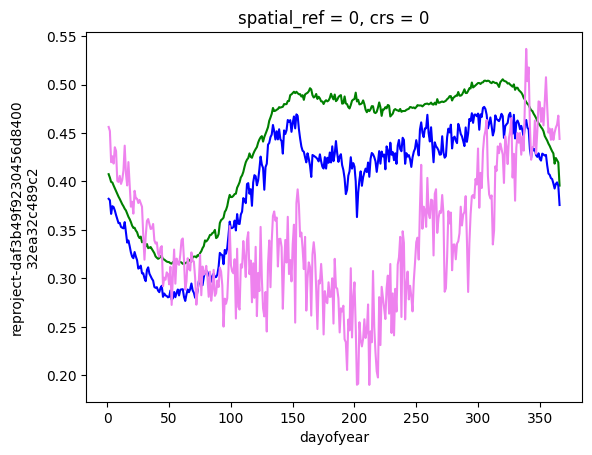

In [ ]:
ds1.where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green")
ds2.where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue")
ds3.where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="violet")

###  Wildfires experiment

1) Simen mountains Semien National Park was started on March 26, 2019

In [ ]:
events = [{"lat":10.32, "lon":39.8, "time_min": "2021-11-20", "time_max": "2021-12-20"}]

In [13]:
shap_path = os.path.join(config["SHAPE"]["base"], "shape-files/Kenya/KEN_adm4.shp")
from utils.function_clns import cut_file
import geopandas as gpd

gdf = gpd.read_file(shap_path)
column = "NAME_3"
gdf[gdf[column].str.contains("Kenya")]

column = "NAME_2"
location = "Mt. Kenya"
list_locations = ["Meru", "Nyeri","Embu", "Nithi","Kirinyaga"]
subset = gdf[gdf[column].isin(list_locations)]
mt_kenya = cut_file(ds_clean.ndvi, subset)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.to_crs(gdf.crs).plot(ax=ax,legend=True, cmap="tab20c")
subset.plot(ax=ax, color="blue", alpha=0.5)

In [26]:
from vegetation.analysis.indices import compute_vci

vci = compute_vci(ds_ndvi)

with ProgressBar():
    vci = vci.load()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 337.47 s


In [39]:
time_min = "2006-02-01"
time_max = "2006-03-20"

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


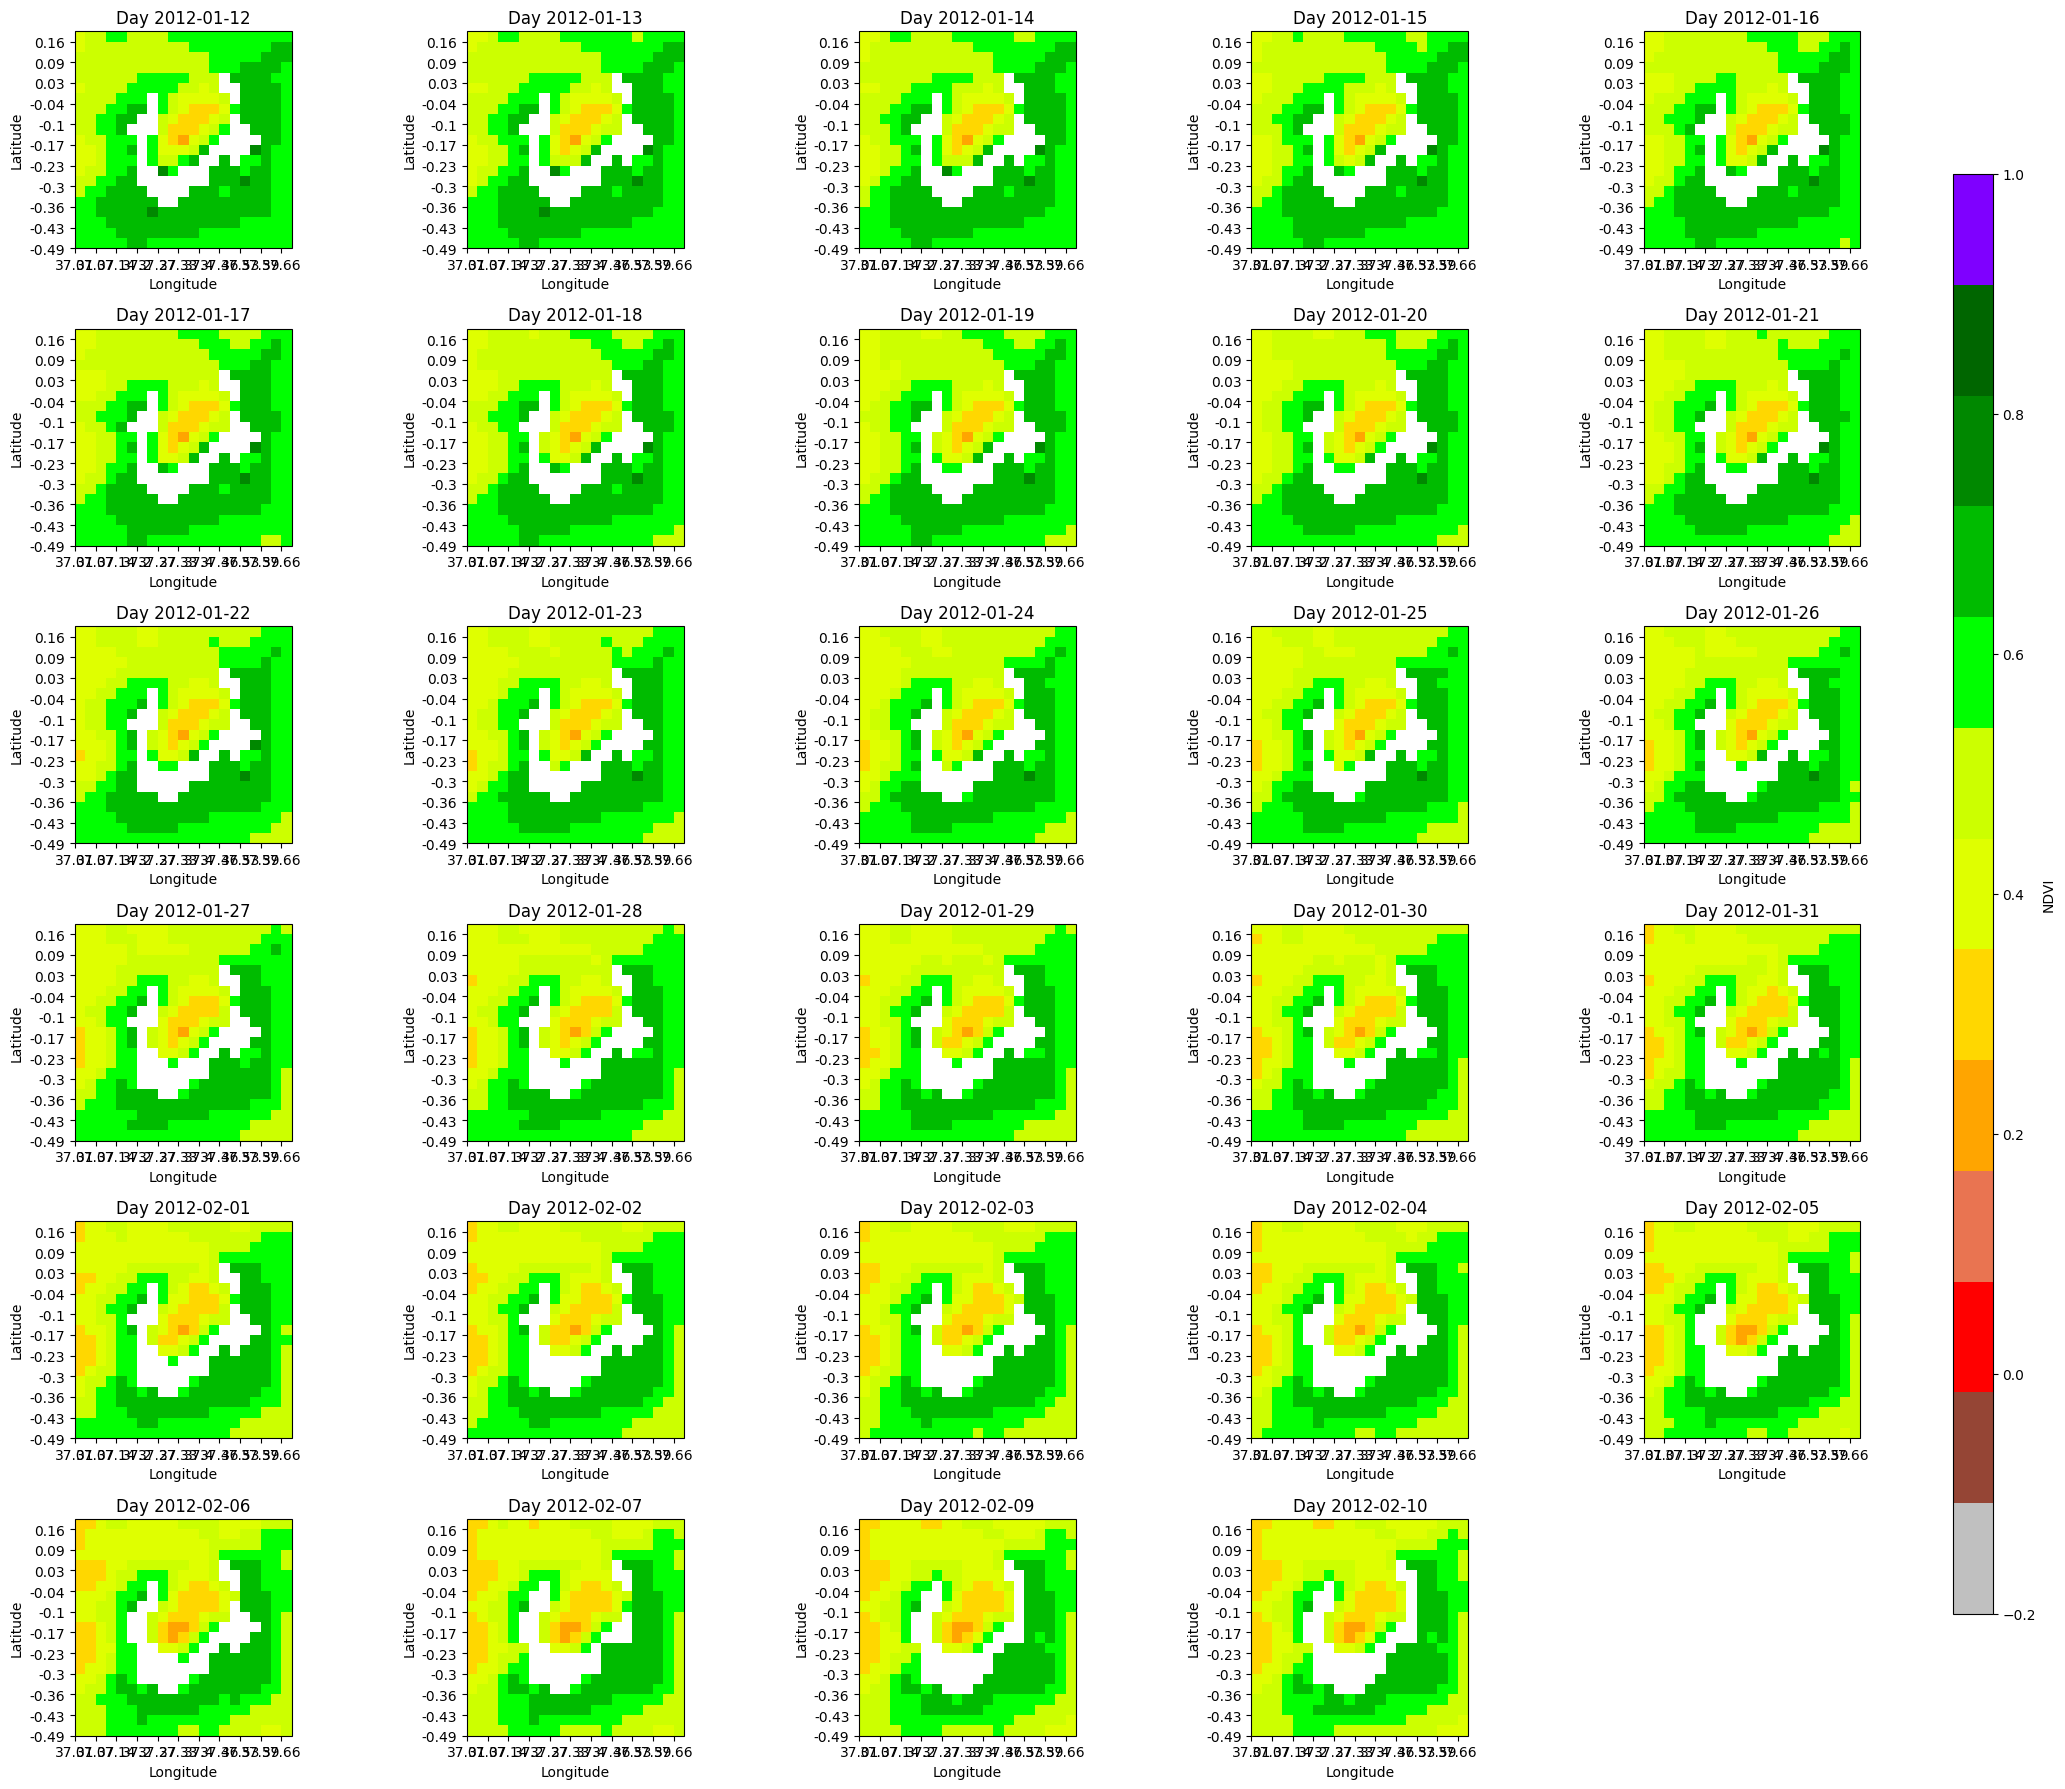

In [48]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt

sub_area = ds_ndvi.sel(lat=slice(-0.5, 0.17 )).sel(lon=slice(37, 37.68))

time_min = "2012-01-12"
time_max = "2012-02-12"

cities = {
    "Timau": (0.05006, 37.14213),
    # "Nanyuki": (0.01667, 37.07283),
    #  "Chuka": (-0.33316, 37.64587),
    # "Kerugoya": (-0.49302, 37.26559),
    # "Meru": (0.053543, 37.648399),
    
}

# extra_area = 1.25

sub_ds = sub_area.sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30)

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


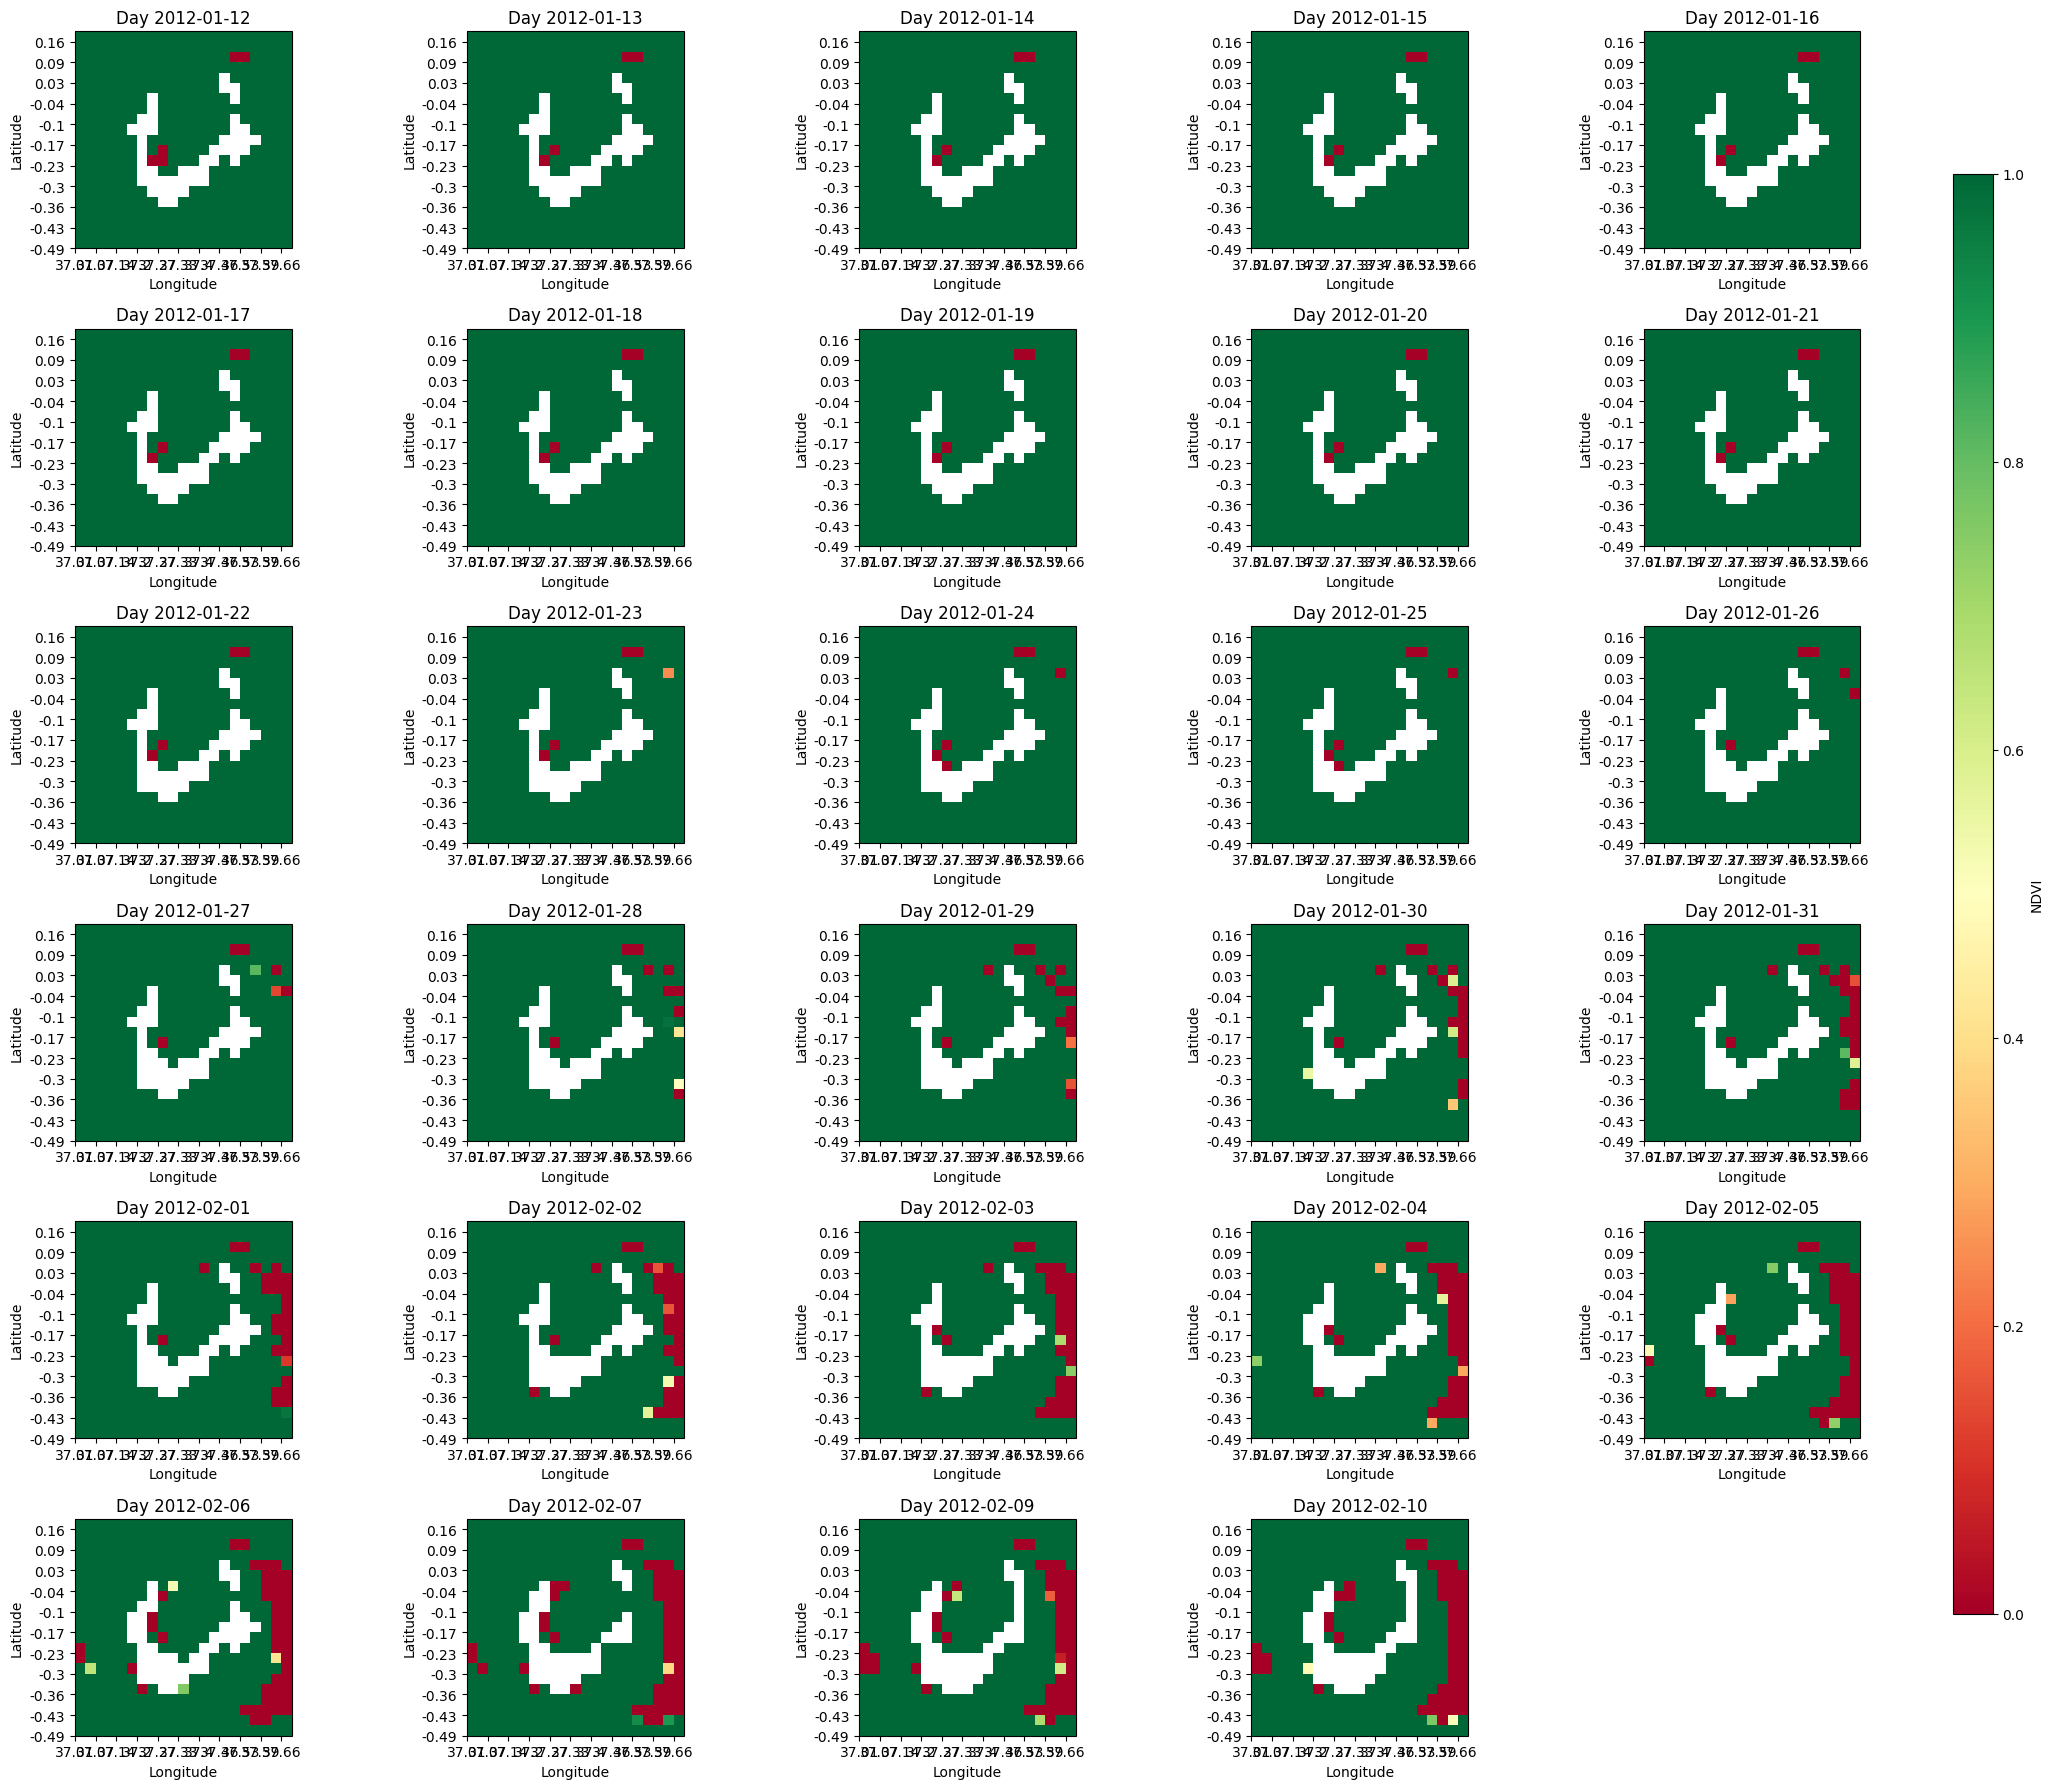

In [49]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt
lat = 0.1521
lon = 37.3084

extra_area = 1.25

sub_ds = vci.where(sub_area<1).sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30, vmin=0, vmax=1, cmap="RdYlGn")

### Metrics

In [ ]:
from vegetation import abs_diff

diff_1 = abs_diff(ds1)
diff_2 = abs_diff(ds2)
diff_3 = abs_diff(ds3)

In [ ]:
print(diff_1.mean().values)
print(diff_2.mean().values)
print(diff_3.mean().values)

0.0015715435
0.030441057
0.109790005


In [ ]:
print(diff_1.where(green_mask==1).mean().values)
print(diff_2.where(green_mask==1).mean().values)
print(diff_3.where(green_mask==1).mean().values)

0.0025605264
0.04984599
0.18859918


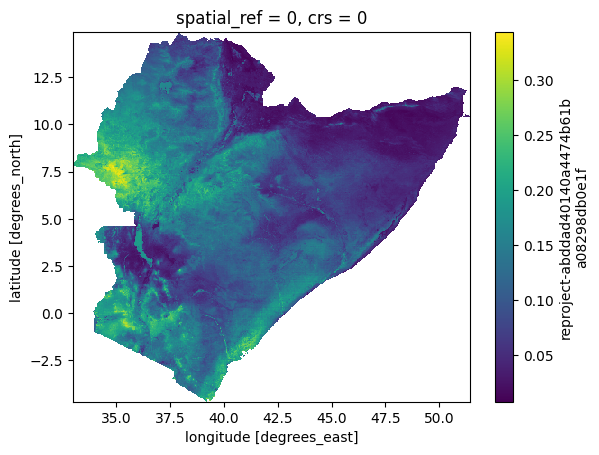

In [ ]:
diff_3.mean(["time"]).plot()

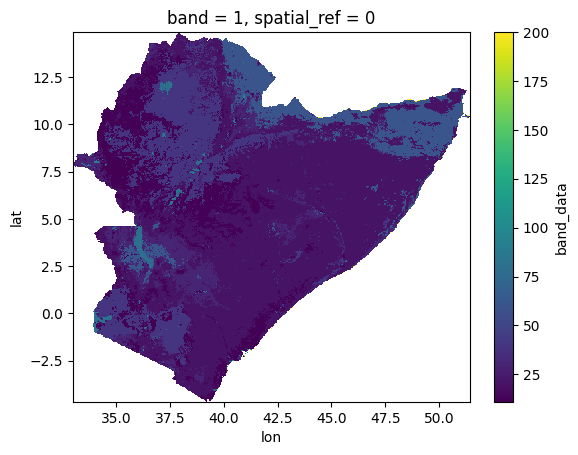

In [ ]:
cover_ds.band_data.transpose("lat","lon").plot()

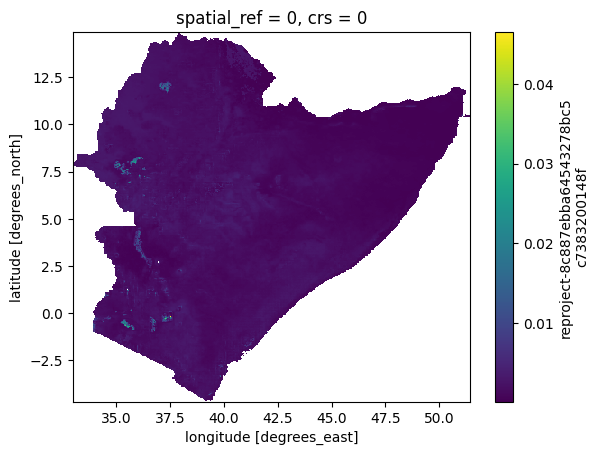

In [ ]:
diff_1.mean(["time"]).plot()

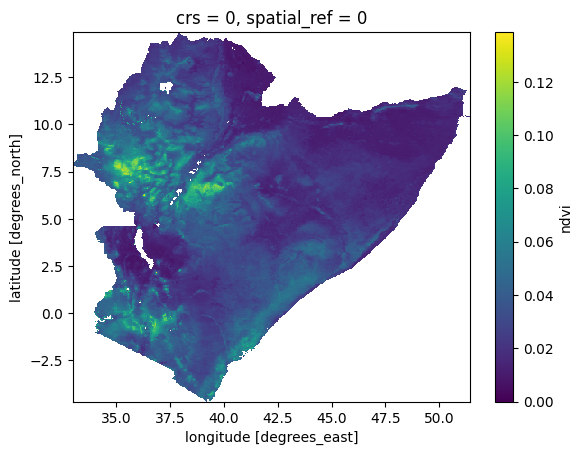

In [ ]:
diff_2.mean(["time"]).plot()

### Cleaning NDVI due to clouds

In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [ ]:
from vegetation.data_collection.modis import EeModis
from utils.function_clns import config

start_date = "2018-08-17"
end_date = "2023-12-31"

modis_data = EeModis(start_date, end_date, name="ref_061")